<a href="https://colab.research.google.com/github/Haniya16/Prdict_Custumer_churn/blob/main/Custumer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Customer Churn (Classification Model)

**Goal:** Build a classifier to predict whether a customer will churn.  
**Dataset:** WA_Fn-UseC_-Telco-Customer-Churn (WA_Fn-UseC_-Telco-Customer-Churn.csv). Download from Kaggle
**Models:** Logistic Regression, Random Forest, Gradient Boosting.  
**Evaluation:** Accuracy, Precision, Recall, F1, ROC-AUC.  
**Explainability:** SHAP and feature importances.

## Mount drive
---


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries
---

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import shap
shap.initjs()
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, roc_curve, auc,
                             confusion_matrix)
from imblearn.over_sampling import SMOTE

sns.set(style='whitegrid')
RND = 42


## Load Dataset
---

In [4]:
file_path = "/content/drive/MyDrive/Colab Notebooks/PredictCustumerChurn/Dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv"

# Load dataset
df = pd.read_csv(file_path)
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## EDA & cleanup
---

In [5]:
# Overview
print("Columns:", df.columns.tolist())
print("\nInfo:")
display(df.info())

# Fix TotalCharges
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Show missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Basic target distribution (Telco uses 'Churn' Yes/No)
print("\nTarget distribution:")
print(df['Churn'].value_counts())
display(df.describe(include='all').T)


Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null

None


Missing values per column:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Target distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## drop ID & feature selection
---

In [6]:
# Drop customerID (not useful as a feature)
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

# Define target and features
TARGET = 'Churn'
X = df.drop(columns=[TARGET])
y = df[TARGET].map({'Yes':1, 'No':0})  # convert to 0/1

# Separate numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)
print("X shape:", X.shape, "y shape:", y.shape)

Numeric cols: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical cols: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
X shape: (7043, 19) y shape: (7043,)


## Preprocessing pipeline
---

In [8]:
# Numeric transformer: median impute + standard scale
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical transformer: most frequent impute + one-hot
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
], remainder='drop')


## train-test split
---

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RND, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train churn rate:", y_train.mean(), "Test churn rate:", y_test.mean())

Train: (5634, 19) Test: (1409, 19)
Train churn rate: 0.2653532126375577 Test churn rate: 0.2654364797728886


## imbalance handling option (class weights or SMOTE)
----

In [10]:
use_smote = False

# Preprocess training and test sets (we need numeric arrays for SMOTE option)
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

print("Preprocessed shapes:", X_train_pre.shape, X_test_pre.shape)

if use_smote:
    sm = SMOTE(random_state=RND)
    X_train_res, y_train_res = sm.fit_resample(X_train_pre, y_train)
    print("After SMOTE:", X_train_res.shape, np.bincount(y_train_res))
else:
    X_train_res, y_train_res = X_train_pre, y_train  # keep original labels
    print("No SMOTE: train counts", np.bincount(y_train_res))


Preprocessed shapes: (5634, 45) (1409, 45)
No SMOTE: train counts [4139 1495]


## evaluation helper & plotting functions
---

In [11]:
def model_metrics(model, X_eval, y_true, name="Model"):
    # X_eval either raw DataFrame for pipeline models or preprocessed arrays for models trained on arrays
    if hasattr(model, "predict_proba") or hasattr(model, "decision_function"):
        y_proba = model.predict_proba(X_eval)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_eval)
    else:
        # fallback: if pipeline doesn't expose predict_proba
        y_proba = model.predict(X_eval)
    y_pred = model.predict(X_eval)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_proba)
    print(f"\n== {name} ==")
    print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}  ROC-AUC: {roc:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
    return dict(name=name, acc=acc, prec=prec, rec=rec, f1=f1, roc=roc, y_proba=y_proba, y_pred=y_pred)

def plot_roc(results, y_true):
    plt.figure(figsize=(8,6))
    for r in results:
        fpr, tpr, _ = roc_curve(y_true, r['y_proba'])
        plt.plot(fpr, tpr, label=f"{r['name']} (AUC={r['roc']:.3f})")
    plt.plot([0,1],[0,1],'--', color='grey')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves'); plt.legend(); plt.grid(); plt.show()

def plot_confusion(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title(title); plt.show()


## Train Logistic Regression
---

In [12]:
# Logistic Regression in pipeline (handles preprocessing inside pipeline)
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RND, solver='liblinear'))
])

if not use_smote:
    lr_pipeline.fit(X_train, y_train)
    X_eval_lr = X_test  # pipeline expects raw DataFrame
    y_eval = y_test
    lr_model_for_eval = lr_pipeline
else:
    # train on preprocessed SMOTE resampled arrays
    from sklearn.linear_model import LogisticRegression as LR_native
    lr_native = LR_native(max_iter=2000, class_weight='balanced', random_state=RND, solver='liblinear')
    lr_native.fit(X_train_res, y_train_res)
    lr_model_for_eval = lr_native
    X_eval_lr = X_test_pre
    y_eval = y_test

res_lr = model_metrics(lr_model_for_eval, X_eval_lr, y_eval, name='Logistic Regression')



== Logistic Regression ==
Accuracy: 0.7381  Precision: 0.5043  Recall: 0.7834  F1: 0.6136  ROC-AUC: 0.8415

Classification Report:
               precision    recall  f1-score   support

           0     0.9022    0.7217    0.8019      1035
           1     0.5043    0.7834    0.6136       374

    accuracy                         0.7381      1409
   macro avg     0.7032    0.7526    0.7078      1409
weighted avg     0.7966    0.7381    0.7519      1409



## Train Random Forest
---

In [13]:
# Random Forest (fast, interpretable via feature importances)
rf = RandomForestClassifier(n_estimators=200, random_state=RND, class_weight='balanced', n_jobs=-1)

if not use_smote:
    rf_pipeline = Pipeline([('preprocessor', preprocessor), ('clf', rf)])
    rf_pipeline.fit(X_train, y_train)
    rf_for_eval = rf_pipeline
    X_eval_rf = X_test
else:
    rf.fit(X_train_res, y_train_res)
    rf_for_eval = rf
    X_eval_rf = X_test_pre

res_rf = model_metrics(rf_for_eval, X_eval_rf, y_eval, name='Random Forest')



== Random Forest ==
Accuracy: 0.7828  Precision: 0.6181  Recall: 0.4759  F1: 0.5378  ROC-AUC: 0.8220

Classification Report:
               precision    recall  f1-score   support

           0     0.8252    0.8937    0.8581      1035
           1     0.6181    0.4759    0.5378       374

    accuracy                         0.7828      1409
   macro avg     0.7216    0.6848    0.6979      1409
weighted avg     0.7702    0.7828    0.7730      1409



## Train Gradient Boosting (sklearn)
---

In [14]:
# Gradient Boosting (sklearn)
gb = GradientBoostingClassifier(n_estimators=200, random_state=RND)

if not use_smote:
    gb_pipeline = Pipeline([('preprocessor', preprocessor), ('clf', gb)])
    gb_pipeline.fit(X_train, y_train)
    gb_for_eval = gb_pipeline
    X_eval_gb = X_test
else:
    gb.fit(X_train_res, y_train_res)
    gb_for_eval = gb
    X_eval_gb = X_test_pre

res_gb = model_metrics(gb_for_eval, X_eval_gb, y_eval, name='Gradient Boosting')



== Gradient Boosting ==
Accuracy: 0.7878  Precision: 0.6254  Recall: 0.5000  F1: 0.5557  ROC-AUC: 0.8354

Classification Report:
               precision    recall  f1-score   support

           0     0.8315    0.8918    0.8606      1035
           1     0.6254    0.5000    0.5557       374

    accuracy                         0.7878      1409
   macro avg     0.7285    0.6959    0.7082      1409
weighted avg     0.7768    0.7878    0.7797      1409



## Compare models & plot ROC
---

,name,acc,prec,rec,f1,roc
0,Logistic Regression,0.738112,0.504303,0.783422,0.613613,0.841466
1,Gradient Boosting,0.787793,0.625418,0.500000,0.555721,0.835417
2,Random Forest,0.782825,0.618056,0.475936,0.537764,0.821965


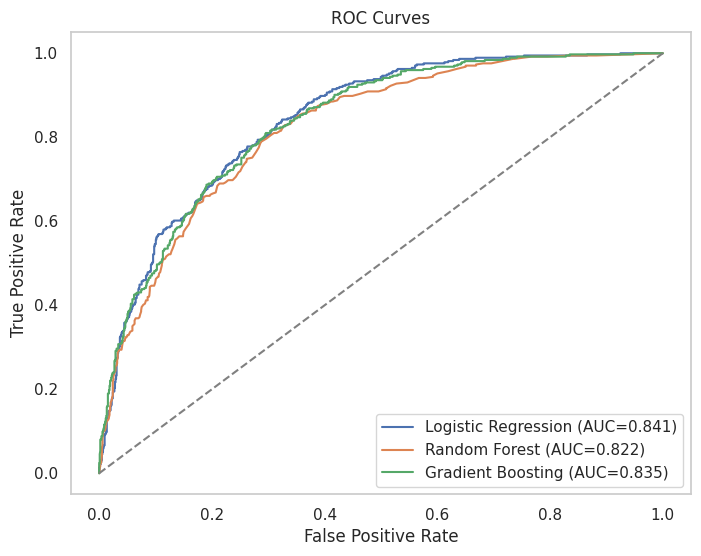

In [16]:
results = [res_lr, res_rf, res_gb]
# Print summary table
summary = pd.DataFrame([{k:v for k,v in r.items() if k in ('name','acc','prec','rec','f1','roc')} for r in results])
display(summary.sort_values('roc', ascending=False).reset_index(drop=True))

# Plot ROC curves using the same y_test
plot_roc(results, y_eval)


## Confusion matrices
---


Confusion matrix: Logistic Regression


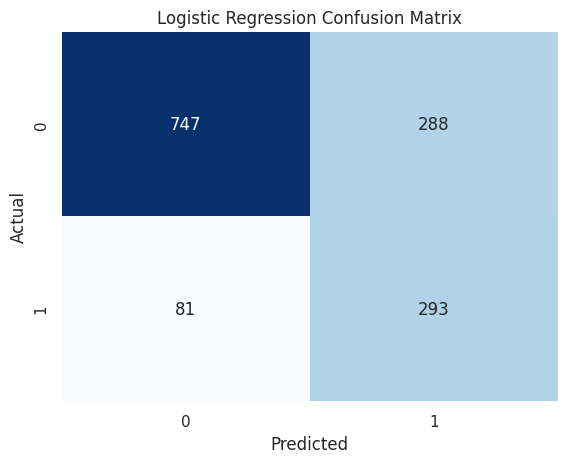


Confusion matrix: Random Forest


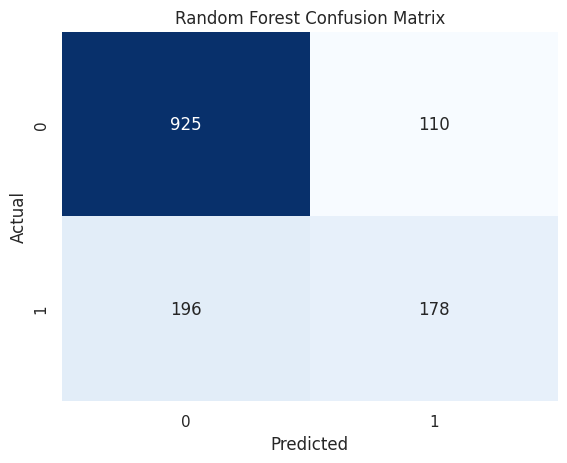


Confusion matrix: Gradient Boosting


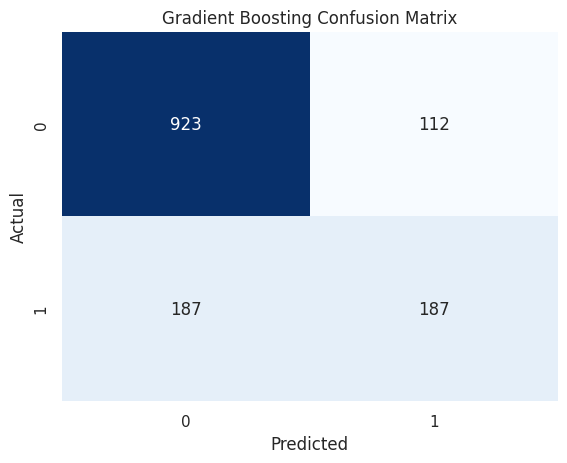

In [18]:
# Show confusion matrix for each model
for r in results:
    print("\nConfusion matrix:", r['name'])
    plot_confusion(y_eval, r['y_pred'], title=f"{r['name']} Confusion Matrix")


## Feature importances (from Random Forest)
---

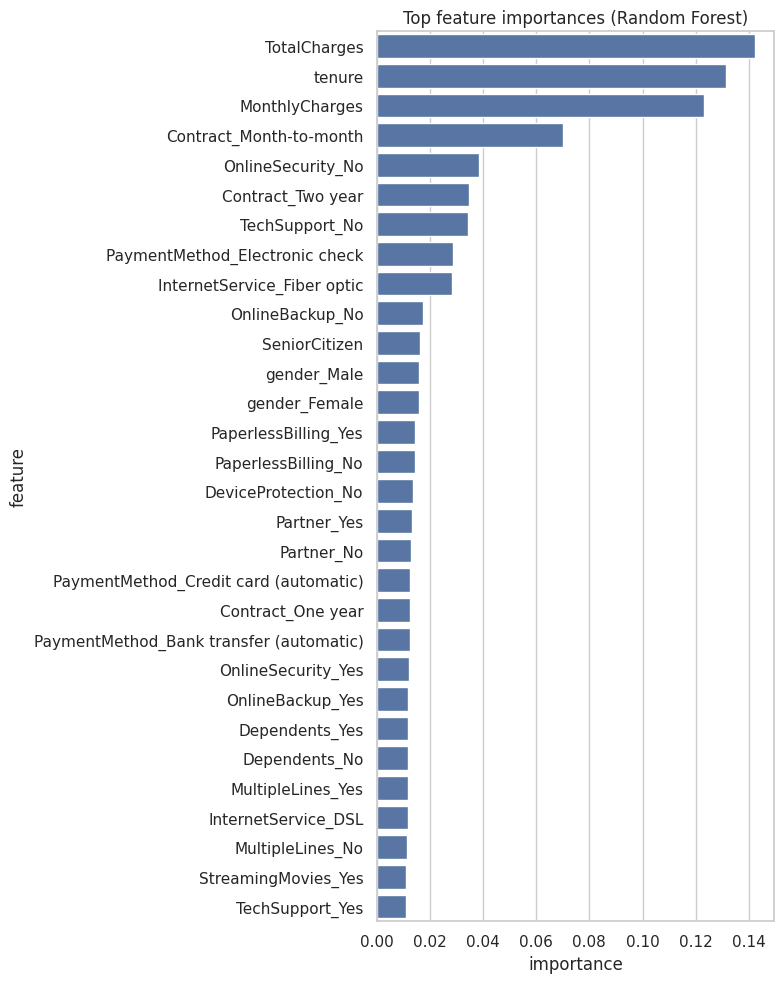

,feature,importance
3,TotalCharges,0.142334
1,tenure,0.131256
2,MonthlyCharges,0.123101
36,Contract_Month-to-month,0.069910
18,OnlineSecurity_No,0.038608
38,Contract_Two year,0.034678
27,TechSupport_No,0.034401
43,PaymentMethod_Electronic check,0.028729
16,InternetService_Fiber optic,0.028286
21,OnlineBackup_No,0.017388


In [19]:
# Get feature names after preprocessing
def get_feature_names_from_preprocessor(preproc, numeric_cols, categorical_cols):
    # numeric
    num_names = numeric_cols
    # categorical one-hot names
    ohe = preproc.named_transformers_['cat'].named_steps['onehot']
    cat_names = list(ohe.get_feature_names_out(categorical_cols))
    return num_names + cat_names

# If rf_for_eval is pipeline, we can extract its preprocessor
if not use_smote:
    preproc_fitted = rf_pipeline.named_steps['preprocessor']
    rf_clf = rf_pipeline.named_steps['clf']
else:
    preproc_fitted = preprocessor
    rf_clf = rf

feat_names = get_feature_names_from_preprocessor(preproc_fitted, numeric_cols, categorical_cols)
importances = rf_clf.feature_importances_

feat_imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False).head(30)
plt.figure(figsize=(8,10))
sns.barplot(x='importance', y='feature', data=feat_imp_df)
plt.title('Top feature importances (Random Forest)')
plt.tight_layout()
plt.show()

# Show table
display(feat_imp_df)


## SHAP explanations
---

X_test_arr shape: (1409, 45)
Number of feature names: 45
SHAP returned 3D array (n_samples, n_features, n_classes); extracted class 1 shap values. shap_vals.shape=(200, 45)


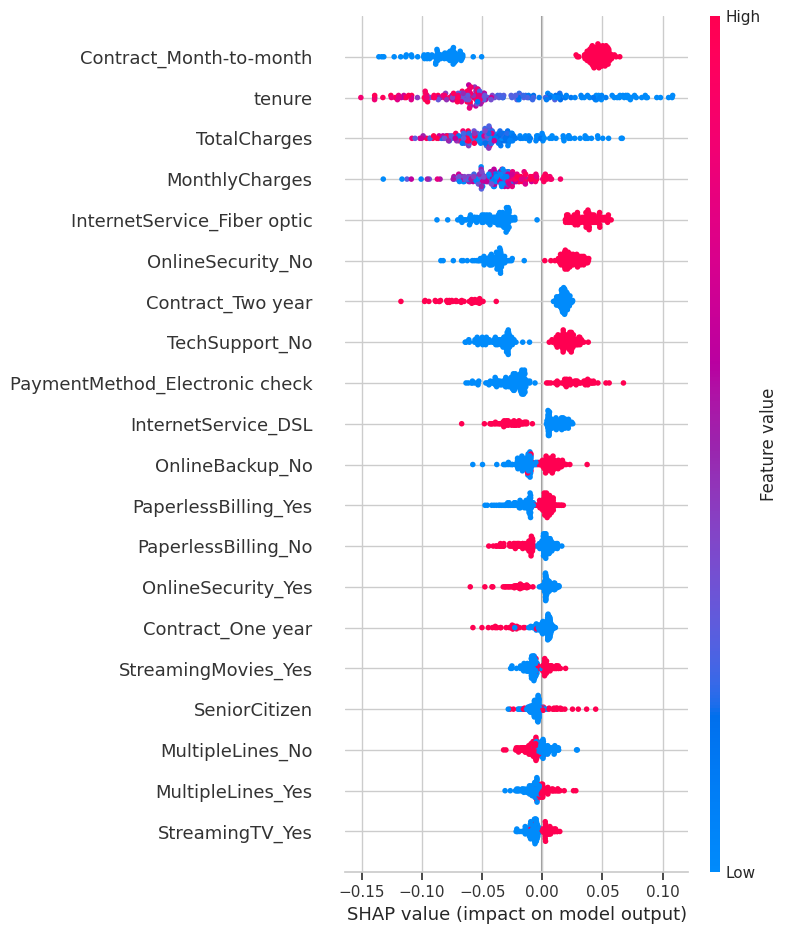

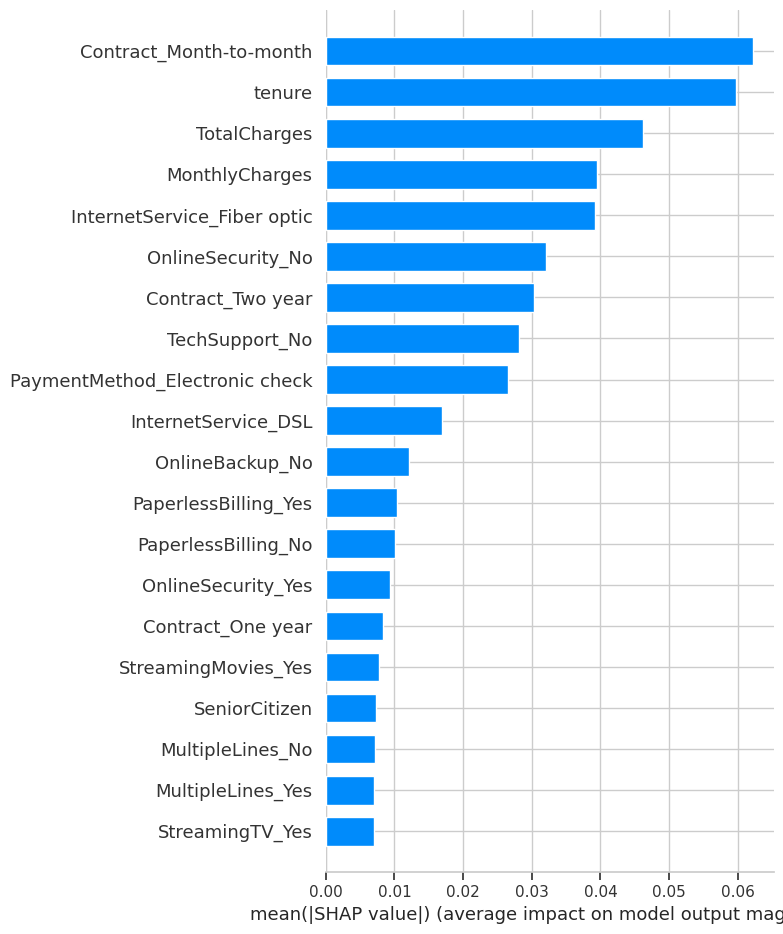

Top SHAP feature: Contract_Month-to-month


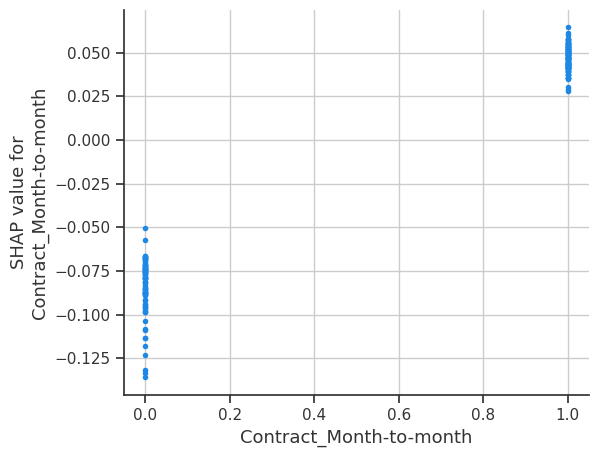

In [30]:
if use_smote:
    X_test_arr = X_test_pre  # already preprocessed numeric array
else:
    # preproc_fitted must be the fitted ColumnTransformer
    X_test_arr = preproc_fitted.transform(X_test)


# numeric_cols and categorical_cols are your lists used earlier
ohe = preproc_fitted.named_transformers_['cat'].named_steps['onehot']
ohe_names = list(ohe.get_feature_names_out(categorical_cols))
feature_names = list(numeric_cols) + ohe_names

# Debug prints: check lengths match
print("X_test_arr shape:", X_test_arr.shape)
print("Number of feature names:", len(feature_names))
if X_test_arr.shape[1] != len(feature_names):
    raise ValueError(f"Feature count mismatch: transformed has {X_test_arr.shape[1]} cols but feature_names length is {len(feature_names)}. Check preprocessor and feature lists.")

# choose sample to speed up plotting
sample = min(200, X_test_arr.shape[0])
X_shap_sample = X_test_arr[:sample]

# rf_clf should be the trained RandomForestClassifier instance
rf_estimator = rf_clf

# get shap values (TreeExplainer)
explainer = shap.TreeExplainer(rf_estimator)
shap_values_raw = explainer.shap_values(X_shap_sample)

# Normalize to a 2D shap array of shape (n_samples, n_features) for class 1
if isinstance(shap_values_raw, list):
    # binary classification -> list of two arrays: [class0, class1]; we want class1
    shap_vals = shap_values_raw[1]
    print("SHAP returned list; using class 1 shap values. shap_vals.shape=", shap_vals.shape)
elif isinstance(shap_values_raw, np.ndarray) and shap_values_raw.ndim == 3:
    # This case indicates (n_samples, n_features, n_classes) for binary classification.
    # Extract values for the positive class (class 1).
    if shap_values_raw.shape[2] == 2:
        shap_vals = shap_values_raw[:, :, 1]
        print(f"SHAP returned 3D array (n_samples, n_features, n_classes); extracted class 1 shap values. shap_vals.shape={shap_vals.shape}")
    else:
        raise ValueError(f"Unexpected 3D SHAP values shape: {shap_values_raw.shape}. Expected (n_samples, n_features, 2) for binary class outputs.")
else:
    # plain 2D array (n_samples, n_features)
    shap_vals = shap_values_raw
    print("SHAP returned 2D array. shap_vals.shape=", shap_vals.shape)

# Final shape check
if shap_vals.shape[1] != len(feature_names):
    raise ValueError(f"After processing, shap_vals has {shap_vals.shape[1]} features but feature_names length is {len(feature_names)}")

# Convert X_shap_sample to DataFrame so SHAP labels columns nicely
X_shap_df = pd.DataFrame(X_shap_sample, columns=feature_names)

# Summary (dot) plot (shows distribution and direction)
plt.figure(figsize=(10,7))
shap.summary_plot(shap_vals, X_shap_df, feature_names=feature_names, plot_type='dot', max_display=20, show=True)

# Summary (bar) plot (mean absolute importance) — useful for reports
plt.figure(figsize=(8,6))
shap.summary_plot(shap_vals, X_shap_df, feature_names=feature_names, plot_type='bar', max_display=20, show=True)

# Find top feature from mean(|shap|)
mean_abs = np.abs(shap_vals).mean(axis=0)
top_idx = np.argmax(mean_abs)
top_feat = feature_names[top_idx]
print("Top SHAP feature:", top_feat)
shap.dependence_plot(top_feat, shap_vals, X_shap_df, feature_names=feature_names, interaction_index=None, show=True)


## Save best model & artifacts
---

In [31]:
# Choose best model by ROC (change criterion if you prefer F1)
best = max(results, key=lambda r: r['roc'])
print("Best model:", best['name'], "ROC:", best['roc'])

# Save corresponding model object
save_dir = "/content/drive/MyDrive/Colab Notebooks/PredictCustumerChurn/Models"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, f"best_model_{best['name'].replace(' ','_')}.joblib")

# Map name to actual model object variable used above
model_map = {
    'Logistic Regression': lr_model_for_eval,
    'Random Forest': rf_for_eval,
    'Gradient Boosting': gb_for_eval
}
joblib.dump(model_map[best['name']], save_path)
print("Saved best model to:", save_path)


Best model: Logistic Regression ROC: 0.8414658089849905
Saved best model to: /content/drive/MyDrive/Colab Notebooks/PredictCustumerChurn/Models/best_model_Logistic_Regression.joblib


# Summary

**Dataset:** Telco Customer Churn CSV (WA_Fn-UseC_-Telco-Customer-Churn.csv) — loaded from Google Drive.

**Preprocessing**
- Converted `TotalCharges` to numeric and imputed missing values.
- Numeric features: median imputation + standard scaling.
- Categorical features: most-frequent imputation + one-hot encoding.

**Models trained**
- Logistic Regression (class_weight='balanced')
- Random Forest (class_weight='balanced')
- Gradient Boosting (sklearn)

**Imbalance handling**
- Default approach: class weights in LR and RF.
- Optionally: SMOTE oversampling by toggling `use_smote=True`.

**Evaluation**
- Metrics: Accuracy, Precision, Recall, F1-score, ROC-AUC.
- Plots: ROC curves for all models, confusion matrices.

**Explainability**
- Feature importance from Random Forest.
- SHAP summary plot for Random Forest to justify decisions.

**Artifacts**
- Best model saved as joblib in: `/content/drive/MyDrive/Colab Notebooks/PredictCustumerChurn/Models/`
